## Gaussian Process Regression
### 1. Introduction
### 2. Data Preparation

In [189]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF 

In [190]:
# pandas will automatically convert the 'NaN' values to np.nan
red_ball_coordinates = pd.read_csv('../interpolated-data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')
red_ball_coordinates

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.0,42.0,87.0,39.0,34.853473,82.531266,44.0,83.0,89.0,83.0,28.886553,118.791444,69.0,122.0
1,0.5,42.5,87.0,40.0,34.853473,82.531266,45.0,84.0,89.0,84.0,28.886553,118.791444,68.5,120.5
2,0.5,43.5,87.0,41.0,34.853473,82.531266,45.0,85.0,89.0,85.0,28.886553,118.791444,68.5,120.5
3,1.0,45.0,87.5,42.0,34.853473,82.531266,45.0,86.0,89.0,86.0,28.886553,118.791444,68.5,120.5
4,1.0,45.5,88.0,43.0,34.853473,82.531266,45.0,86.0,90.0,87.0,28.886553,118.791444,68.5,120.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.000000,59.000000,111.0,59.0,59.5,69.0,54.500000,105.000000,68.0,118.5
497,67.0,9.0,55.0,26.0,63.000000,58.000000,110.0,58.0,59.5,69.0,54.000000,103.000000,68.0,118.5
498,66.0,8.0,55.0,26.0,62.000000,57.000000,109.0,57.0,59.5,69.0,53.000000,102.500000,68.0,118.5
499,65.0,5.0,55.0,26.0,61.000000,55.000000,107.5,55.0,59.5,69.0,52.000000,101.000000,68.0,118.5


In [191]:
xyz_coordinates = pd.read_csv('../interpolated-data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',')
xyz_coordinates

,x,y,z
0,7.140000,3.070000,15.00000
1,10.140000,3.070000,15.00000
2,10.140000,3.070000,15.00000
3,10.140000,3.070000,15.00000
4,10.138330,3.169981,15.09998
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


In [192]:
xyz_coordinates = xyz_coordinates.reset_index(drop=True)
# remove the first 4 rows
xyz_coordinates = xyz_coordinates.iloc[4:]
xyz_coordinates

,x,y,z
4,10.138330,3.169981,15.09998
5,10.133340,3.269852,15.19985
6,10.125010,3.369500,15.29950
7,10.113370,3.468816,15.39882
8,10.098430,3.567688,15.49769
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


### 3. Data Preprocessing

In [193]:
# split into features and target
X = red_ball_coordinates
# remove the first 3
y = xyz_coordinates

In [194]:
from sklearn.impute import SimpleImputer
# scale the features and the target
from sklearn.preprocessing import StandardScaler

#### 3.1. Impute the NaN values with mean SimpleImputer

In [195]:
imputer = SimpleImputer(strategy='mean')
X_imputed_mean = imputer.fit_transform(X)
y_imputed_mean = imputer.fit_transform(y)

#### 3.2. Impute the NaN values with median SimpleImputer

In [196]:
imputer = SimpleImputer(strategy='median')
X_imputed_median = imputer.fit_transform(X)
y_imputed_median = imputer.fit_transform(y)

### 3.3. Impute the NaN values with KNNImputer

In [197]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)
X_imputed_knn = imputer.fit_transform(X)

### 4. Gaussian Process Regression

In [198]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_imputed_knn, y_imputed_median, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (101, 14), (400, 3), (101, 3))

In [199]:
y_train_x = y_train[:, 0]
y_train_y = y_train[:, 1]
y_train_z = y_train[:, 2]

y_test_x = y_test[:, 0]
y_test_y = y_test[:, 1]
y_test_z = y_test[:, 2]

In [200]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5))
gp_x = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_y = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gp_z = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

In [201]:
y_train_x_scaled = scaler_y.fit_transform(y_train_x.reshape(-1, 1))
y_train_y_scaled = scaler_y.fit_transform(y_train_y.reshape(-1, 1))
y_train_z_scaled = scaler_y.fit_transform(y_train_z.reshape(-1, 1))

In [202]:
X_scaled_train = scaler_X.fit_transform(X_train)

In [203]:
gp_x.fit(X_scaled_train, y_train_x_scaled)
gp_y.fit(X_scaled_train, y_train_y_scaled)
gp_z.fit(X_scaled_train, y_train_z_scaled)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20)

### 5. Predictions

In [204]:
X_test_scaled = scaler_X.transform(X_test)
y_pred_x, sigma_x = gp_x.predict(X_test_scaled, return_std=True)
y_pred_y, sigma_y = gp_y.predict(X_test_scaled, return_std=True)
y_pred_z, sigma_z = gp_z.predict(X_test_scaled, return_std=True)

In [205]:
y_pred_x = scaler_y.inverse_transform(y_pred_x.reshape(-1, 1))
y_pred_y = scaler_y.inverse_transform(y_pred_y.reshape(-1, 1))
y_pred_z = scaler_y.inverse_transform(y_pred_z.reshape(-1, 1))

### 6. Conclusion

In [206]:
from utils.evaluate import evaluate_model

evaluate_model(y_test[:, 0], y_pred_x, 'Gaussian Process Regression X')
evaluate_model(y_test[:, 1], y_pred_y, 'Gaussian Process Regression Y')
evaluate_model(y_test[:, 2], y_pred_z, 'Gaussian Process Regression Z')

Mean Squared Error on Gaussian Process Regression X Set: 66.89843524539397
Mean Absolute Error on Gaussian Process Regression X Set: 8.171693759958856
R2 Score on Gaussian Process Regression X set: -12.922488446683605
Mean Squared Error on Gaussian Process Regression Y Set: 143.04379910800304
Mean Absolute Error on Gaussian Process Regression Y Set: 11.959054228307673
R2 Score on Gaussian Process Regression Y set: -34.71537042406866
Mean Squared Error on Gaussian Process Regression Z Set: 0.02566494269602745
Mean Absolute Error on Gaussian Process Regression Z Set: 0.053680581548135396
R2 Score on Gaussian Process Regression Z set: 0.9935919406096574


(0.02566494269602745, 0.053680581548135396, 0.9935919406096574)

#### 6.1 Visualize the results
#### 6.1.1 3D Visualization of the predicted ball trajectory

#### 6.1.2 Gaussian Process In Time with Covariance For Each Dimension

ValueError: 'y1' is not 1-dimensional

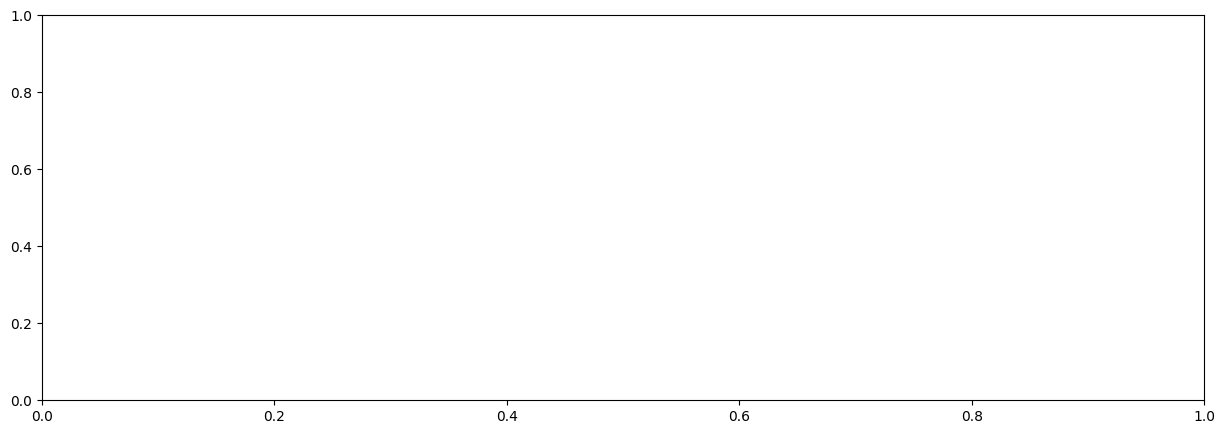

In [208]:
from utils.plot_maker_gaussian_process import gaussian_process_plot
# for the x dimension
gaussian_process_plot(y_test_x, y_pred_x, sigma_x)

In [ ]:
# for the y dimension
gaussian_process_plot(y_test_y, y_pred_y, sigma_y)

In [ ]:
# for the z dimension
gaussian_process_plot(y_test_z[:100], y_pred_z[:100], sigma_z[:100])